# Baseline network + pruning + quantization

This notebook trains the baseline network with exact same architecture as the one in paper [Recognition of handwritten Latin characters with diacritics using CNN](https://journals.pan.pl/dlibra/publication/136210/edition/119099/content/bulletin-of-the-polish-academy-of-sciences-technical-sciences-recognition-of-handwritten-latin-characters-with-diacritics-using-cnn-lukasik-edyta-charytanowicz-malgorzata-milosz-marek-tokovarov-michail-kaczorowska-monika-czerwinski-dariusz-zientarski-tomasz-2021-69-no-1?language=en)

Model architecture description:

"The architecture of the concrete CNN is shown in Fig. 2.
The input is a 32x32 binarized matrix. The input is then prop-
agated through 12 adaptable layers. First come two convolu-
tional layers having 32 filters with the size of 3x3 and stride 1.
Secondly, the output of the convolutional layer is fed to the
ReLU function. The output is down-sampled using a max-pool-
ing operation with a 2x2 stride. Next, the dropout technique is
used with the coefficient 0.25. The four operations (two con-
volutions, nonlinearity, max-pooling, and dropout) are repeated,
using 64 filters for the convolutional layers. The output of the
last layer is then flattened and fed through a fully connected
layer with 256 neurons and ReLU nonlinearities, dropped out
with the 0.25 coefficient, and a final output layer is fully con-
nected with a Softmax activation function. The Adam optimizer
and the cross-entropy loss function were used in the network. 
The output is a probability distribution over 89 classes."


Additionally, this network was pruned and quantized after training.



After training, model is serialized and uploaded to W&B project.

In [ ]:
! pip install tensorflow-model-optimization

In [1]:
import pathlib
import shutil
import os
import time
import datetime
import numpy as np
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import zipfile

from typing import List

def load_data(run, artifact_name = "phcd_paper_splits_tfds") -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list

def get_readable_class_labels(subset = 'phcd_paper'):
    if subset == 'phcd_paper':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c',
        'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'ą', 'ć', 'ę',
        'ł', 'ń', 'ó', 'ś', 'ź', 'ż', 'Ą', 'Ć', 'Ę', 'Ł', 'Ń', 'Ó', 'Ś',
        'Ź', 'Ż', '+', '-', ':', ';', '$', '!', '?', '@', '.']
    elif subset == 'uppercase':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Ą', 'Ć', 
        'Ę', 'Ł', 'Ń', 'Ó', 'Ś', 'Ź', 'Ż']
    elif subset == 'lowercase':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ą', 'ć',
        'ę', 'ł', 'ń', 'ó', 'ś', 'ź', 'ż']
    elif subset == 'numbers':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    elif subset == 'uppercase_no_diacritics':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    elif subset == 'lowercase_no_diacritics':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

def calculate_accuracy_per_class(model, test_dataset, test_dataset_name):
    '''
    Calculates the accuracy per class for a given model and test dataset.

    Returns dict with class labels as keys and accuracy as values.
    '''
        
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)
    # get labels
    y_true = test_dataset.map(lambda x, y: y).as_numpy_iterator()
    y_true = np.concatenate(list(y_true))
    # calculate accuracy per class
    labels = get_readable_class_labels(test_dataset_name)
    class_accuracy = np.zeros(len(labels))
    for i, label in enumerate(labels):
        class_accuracy[i] = np.sum(y_pred[y_true == i] == i) / np.sum(y_true == i)
    return { label: acc for label, acc in zip(labels, class_accuracy) }
    

def plot_accuracy_per_class(class_accuracy_dict):
    plt.figure(figsize=(10, 5))
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    plt.bar(labels, class_accuracy)
    plt.xticks(labels)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per class")
    plt.show()


def accuracy_table(class_accuracy_dict):
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    return wandb.Table(columns=["Class", "Accuracy"], data=list(zip(labels, class_accuracy)))

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def get_number_of_examples(ds: tf.data.Dataset) -> int:
    """
    Returns the number of examples in a dataset.
    """
    return sum(1 for _ in ds)

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def calculate_model_compressed_size_on_disk(path: str) -> int:
    compressed_path = path + ".zip"
    with zipfile.ZipFile(compressed_path, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(path)
    return pathlib.Path(compressed_path).stat().st_size    

def calculate_model_num_parameters(model: tf.keras.Model) -> int:
    return model.count_params()

def calculate_model_flops(summary) -> float:
    # from run.summary get GFLOPs or GFLOPS whichever is available
    if "GFLOPs" in summary.keys():
        return summary.get("GFLOPs")
    elif "GFLOPS" in summary.keys():
        return summary.get("GFLOPS")
    else:
        return 0

def calculate_model_throughput(model, test_dataset, batch_size) -> float:
    '''
    Calculates the average throughput of a model over 50 batch predictions of 100 batches, in images per second.
    '''
    output = []
    for _ in range(50):
        start = time.time()
        model.predict(test_dataset.take(100))
        end = time.time()
        output.append((100 * batch_size) / (end - start))
    return np.mean(output)

def plot_history(history, title):
    plt.figure(figsize=(15,7))
    plt.suptitle(title)
    
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

2023-02-03 16:27:18.704814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Available devices: ", tf.config.list_physical_devices())

Num GPUs Available:  1
Available devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-02-03 16:27:21.565616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:27:21.580752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:27:21.581061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.


# Baseline model

In [3]:
defaults = dict(
    batch_size=32*2,
    epochs=60,    
    optimizer="adam"
)

artifact_base_name = "lowercase"
model_name = f"architecture-4-{artifact_base_name}"
artifact_name = f"{artifact_base_name}_splits_tfds" # "phcd_paper_splits_tfds
run = wandb.init(project="master-thesis", job_type="training", name=model_name, config=defaults, tags=[artifact_name])
    
# hyperparameters
epochs = wandb.config.epochs
bs = wandb.config.batch_size

ds_train, ds_test, ds_val = load_data(run, artifact_name=artifact_name)

num_classes = get_number_of_classes(ds_val)

ds_train = preprocess_dataset(ds_train, batch_size=bs)
ds_val = preprocess_dataset(ds_val, batch_size=bs)
ds_test = preprocess_dataset(ds_test, batch_size=bs, cache=False)

'''
The architecture of the concrete CNN is shown in Fig. 2.
The input is a 32x32 binarized matrix. 
The input is then propagated through 12 adaptable layers. 
First come two convolutional layers having 32 filters with the size of 3x3 and stride 1.
Secondly, the output of the convolutional layer is fed to the
ReLU function. The output is down-sampled using a max-pool-
ing operation with a 2x2 stride. Next, the dropout technique is
used with the coefficient 0.25. The four operations (two con-
volutions, nonlinearity, max-pooling, and dropout) are repeated,
using 64 filters for the convolutional layers. The output of the
last layer is then flattened and fed through a fully connected
layer with 256 neurons and ReLU nonlinearities, dropped out
with the 0.25 coefficient, and a final output layer is fully con-
nected with a Softmax activation function. The Adam optimizer
and the cross-entropy loss function were used in the network
[24]. The output is a probability distribution over 89 classes.
'''

model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
            tf.keras.layers.Conv2D(32,kernel_size=(3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256*4, activation="relu"),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
            ]
        )

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


wandb:   9 of 9 files downloaded.  
2023-02-03 16:27:25.953743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-03 16:27:25.954656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:27:25.954982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:27:25.955274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:27:27.008905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:27:27.009223: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Epoch 1/60


2023-02-03 16:27:27.785757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:27:27.785809: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-02-03 16:27:27.785980: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-02-03 16:27:27.786476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:27:27.786684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:27:27.786880: I tensor

2408/2408 [==============================] - 30s 10ms/step - loss: 0.6733 - accuracy: 0.7988 - val_loss: 0.3476 - val_accuracy: 0.8939
Epoch 2/60
2408/2408 [==============================] - 22s 9ms/step - loss: 0.3737 - accuracy: 0.8880 - val_loss: 0.2828 - val_accuracy: 0.9141
Epoch 3/60
2408/2408 [==============================] - 23s 9ms/step - loss: 0.3219 - accuracy: 0.9029 - val_loss: 0.2491 - val_accuracy: 0.9233
Epoch 4/60
2408/2408 [==============================] - 23s 10ms/step - loss: 0.2906 - accuracy: 0.9113 - val_loss: 0.2327 - val_accuracy: 0.9268
Epoch 5/60
2408/2408 [==============================] - 23s 10ms/step - loss: 0.2660 - accuracy: 0.9176 - val_loss: 0.2119 - val_accuracy: 0.9317
Epoch 6/60
2408/2408 [==============================] - 23s 10ms/step - loss: 0.2454 - accuracy: 0.9233 - val_loss: 0.1948 - val_accuracy: 0.9376
Epoch 7/60
2408/2408 [==============================] - 23s 10ms/step - loss: 0.2297 - accuracy: 0.9274 - val_loss: 0.1832 - val_accuracy

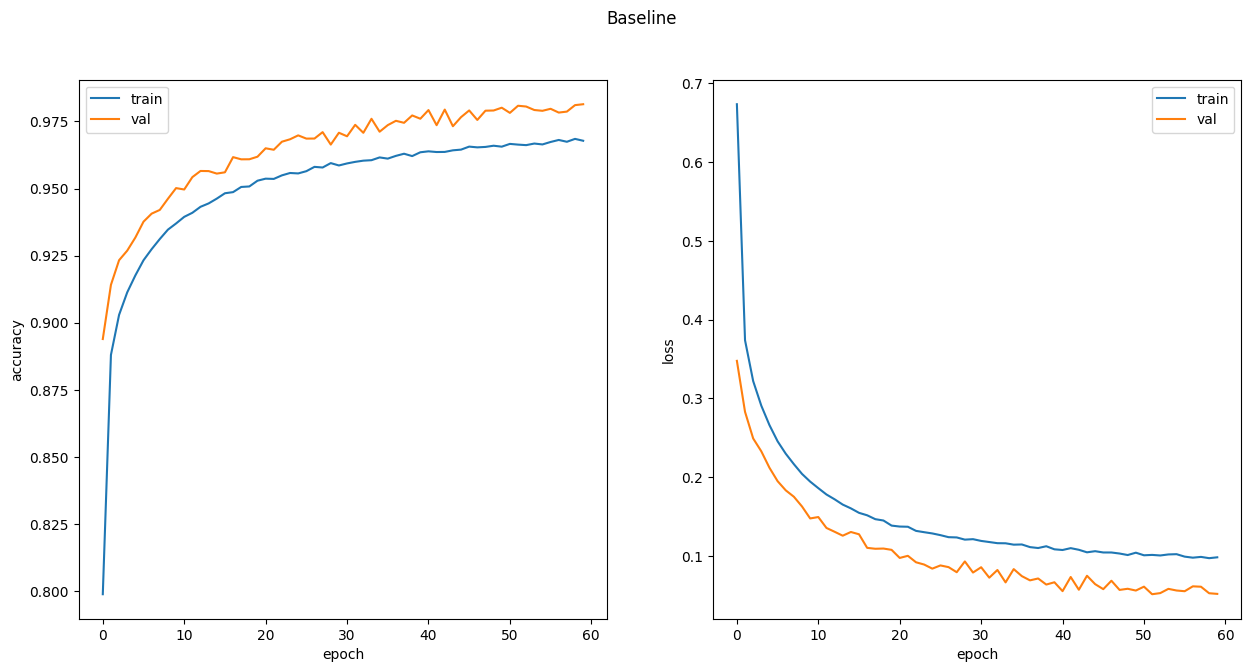

In [4]:
history = model.fit(
    ds_train,
    epochs=wandb.config.epochs,
    validation_data=ds_val,
    callbacks=[
        WandbCallback(
            compute_flops=True, 
            save_model=False, 
            log_weights=False, 
            log_gradients=False
        )
    ],
)

plot_history(history, "Baseline")
tf.keras.models.save_model(model, 'model_baseline.h5', include_optimizer=False)

344/344 [==============================] - 1s 3ms/step


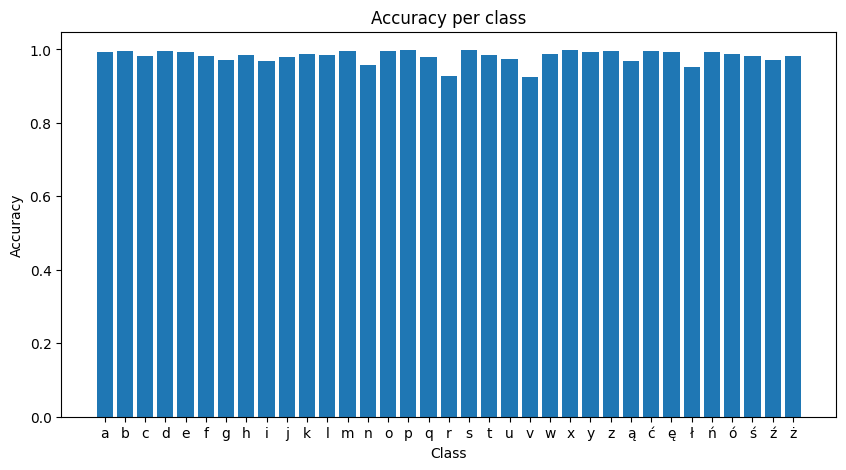

{'test_loss': 0.05092782899737358, 'test_accuracy': 0.9815008640289307, 'num_parameters': 590307, 'compressed_disk_size': 2208670, 'model_flops': 0.005409801, 'throughput': 16806.317076125866, 'accuracy_per_class': <wandb.data_types.Table object at 0x7f9ff408c3d0>}


accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
compressed_disk_size,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_flops,▁
num_parameters,▁
test_accuracy,▁
test_loss,▁
throughput,▁
val_accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇███▇██████████
val_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁


In [5]:
# evaluate model on ds_test and log to wandb
test_loss_before, test_acc_before = model.evaluate(ds_test)

# calculate model size on disk, flops and number of parameters
flops = calculate_model_flops(wandb.run.summary)
num_parameters = calculate_model_num_parameters(model)
compressed_disk_size = calculate_model_compressed_size_on_disk('model_baseline.h5')
throughput = calculate_model_throughput(model, ds_test, wandb.config.batch_size)
class_acc = calculate_accuracy_per_class(model, ds_test, artifact_base_name)

data_to_log = {
    "test_loss": test_loss_before, 
    "test_accuracy": test_acc_before, 
    "num_parameters": num_parameters,
    "compressed_disk_size": compressed_disk_size, 
    "model_flops": flops,
    "throughput": throughput,
    "accuracy_per_class": accuracy_table(class_acc)
    }
plot_accuracy_per_class(class_acc)
print(data_to_log)
wandb.log(data_to_log)

# upload model to wandb
wandb.save('model_baseline.h5')
run.finish()

# Quantization - allows for better accuracy

In [6]:
run = wandb.init(project="master-thesis", job_type="training", name=f"{model_name}_quantized", config=defaults, tags=[artifact_name, "optimized"])

quantize_model = tfmot.quantization.keras.quantize_model

quant_epochs = 2
base_model = tf.keras.models.load_model('model_baseline.h5')

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(base_model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 32, 32, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 32, 32, 32)       387       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 16, 16, 32)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 14, 14, 64)       18627     
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 7, 7, 64)         1

Epoch 1/2


2023-02-03 16:50:46.533757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:50:46.533825: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-02-03 16:50:46.533983: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-02-03 16:50:46.534786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:50:46.535151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:50:46.535454: I tensor

2408/2408 [==============================] - 60s 24ms/step - loss: 0.1060 - accuracy: 0.9655 - val_loss: 0.0672 - val_accuracy: 0.9773
Epoch 2/2
2408/2408 [==============================] - 58s 24ms/step - loss: 0.1049 - accuracy: 0.9652 - val_loss: 0.0542 - val_accuracy: 0.9800


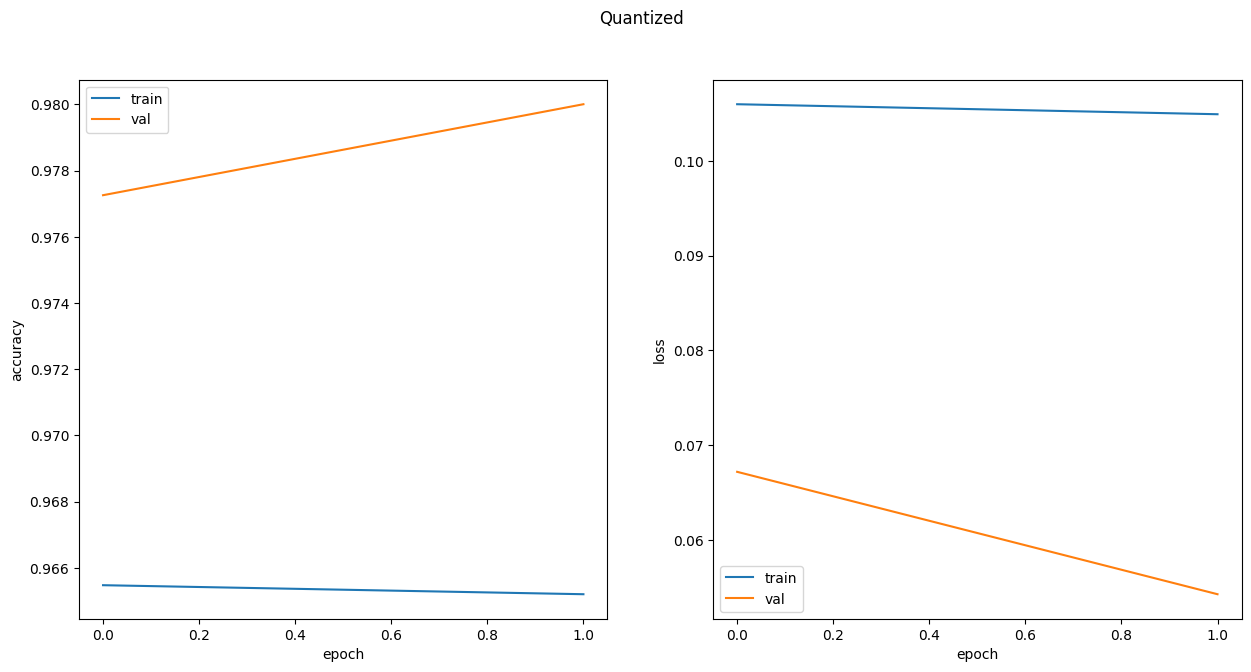

In [7]:
history = q_aware_model.fit(
    ds_train,
    epochs=quant_epochs,
    validation_data=ds_val,
    callbacks=[
        WandbCallback(
            compute_flops=True, 
            save_model=False, 
            log_weights=False, 
            log_gradients=False
        )
    ],
)


plot_history(history, "Quantized")
tf.keras.models.save_model(q_aware_model, 'model_quantized.h5', include_optimizer=False)

344/344 [==============================] - 2s 7ms/step


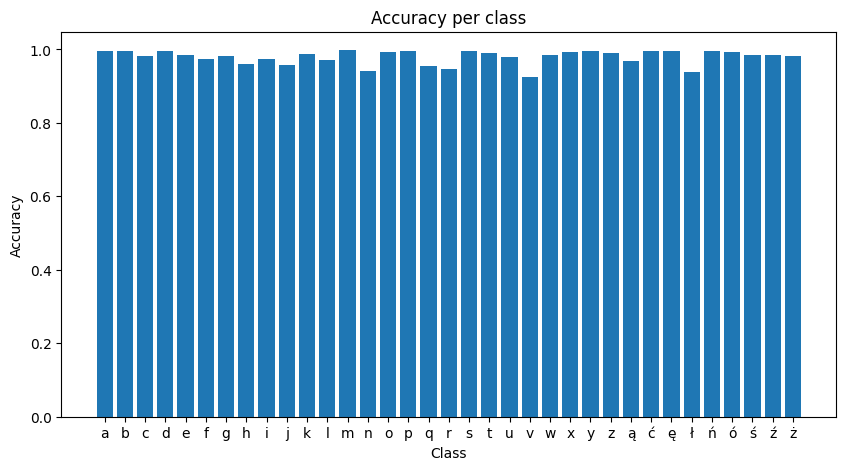

{'test_loss': 0.05092782899737358, 'test_accuracy': 0.9815008640289307, 'num_parameters': 590660, 'compressed_disk_size': 2213573, 'model_flops': 0.005409801, 'throughput': 7940.178663702204, 'accuracy_per_class': <wandb.data_types.Table object at 0x7fa0044974c0>}


accuracy,█▁
compressed_disk_size,▁
epoch,▁█
loss,█▁
model_flops,▁
num_parameters,▁
test_accuracy,▁
test_loss,▁
throughput,▁
val_accuracy,▁█
val_loss,█▁


In [8]:
# evaluate model on ds_test and log to wandb
test_loss_quantize, test_acc_quantize = model.evaluate(ds_test)

# calculate model size on disk, flops and number of parameters
flops = calculate_model_flops(wandb.run.summary)
num_parameters = calculate_model_num_parameters(q_aware_model)
compressed_disk_size = calculate_model_compressed_size_on_disk('model_quantized.h5')
throughput = calculate_model_throughput(q_aware_model, ds_test, wandb.config.batch_size)
class_acc = calculate_accuracy_per_class(q_aware_model, ds_test, artifact_base_name)

data_to_log = {
    "test_loss": test_loss_quantize, 
    "test_accuracy": test_acc_quantize, 
    "num_parameters": num_parameters,
    "compressed_disk_size": compressed_disk_size, 
    "model_flops": flops,
    "throughput": throughput,
    "accuracy_per_class": accuracy_table(class_acc)
    }
plot_accuracy_per_class(class_acc)
print(data_to_log)
wandb.log(data_to_log)
run.finish()

# Pruning model - allows for smaller size (after compression)

In [9]:
run = wandb.init(project="master-thesis", job_type="training", name=f"{model_name}_pruned", config=defaults, tags=[artifact_name, "optimized"])

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

prune_epochs = 4
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
  }

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

base_model = tf.keras.models.load_model('model_baseline.h5')
model_sparse = prune_low_magnitude(base_model, **pruning_params)

# Use smaller learning rate for fine-tuning
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_sparse.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy'])

model_sparse.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 32, 32, 32)       610       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 16, 16, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 14, 14, 64)       36930     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 7, 7, 64)         1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                        

2023-02-03 16:54:07.194067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:54:07.194131: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-02-03 16:54:07.194369: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-02-03 16:54:07.194907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:54:07.195099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:54:07.195282: I tensor

Epoch 1/4


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2408/2408 [==============================] - 47s 18ms/step - loss: 0.2455 - accuracy: 0.9237 - val_loss: 0.1359 - val_accuracy: 0.9574
Epoch 2/4
2408/2408 [==============================] - 43s 18ms/step - loss: 0.1946 - accuracy: 0.9384 - val_loss: 0.1106 - val_accuracy: 0.9648
Epoch 3/4
2408/2408 [==============================] - 43s 18ms/step - loss: 0.1716 - accuracy: 0.9450 - val_loss: 0.0979 - val_accuracy: 0.9679
Epoch 4/4
2408/2408 [==============================] - 43s 18ms/step - loss: 0.1612 - accuracy: 0.9488 - val_loss: 0.0900 - val_accuracy: 0.9705


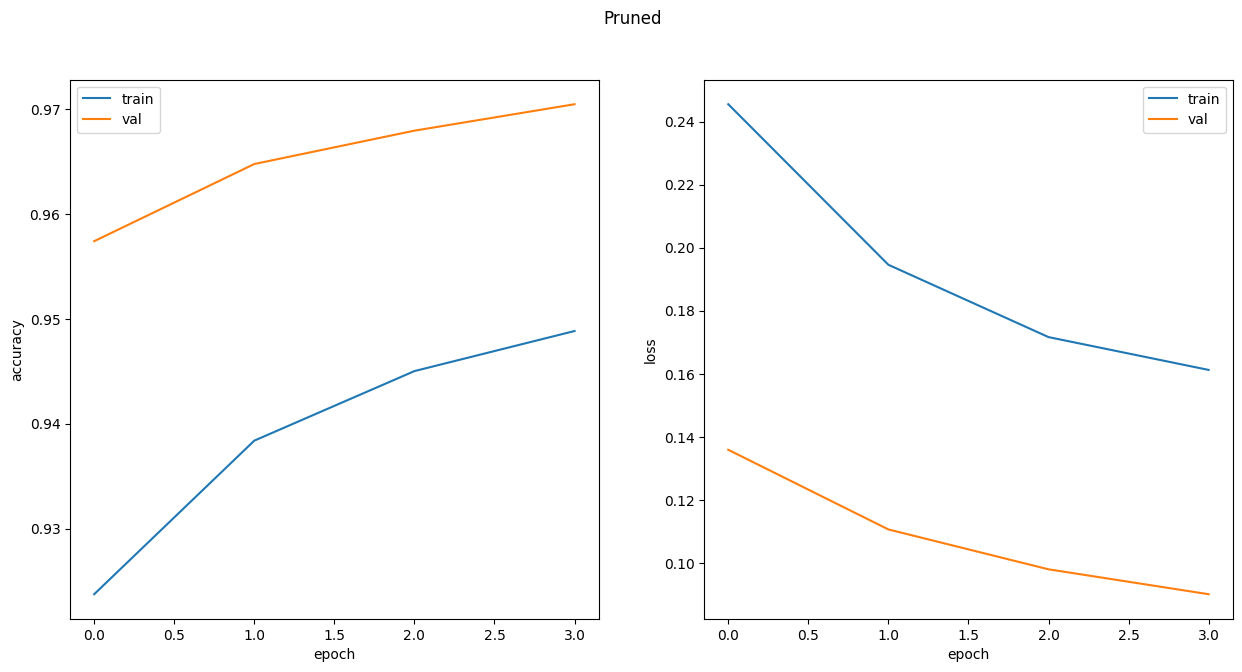

In [10]:
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    WandbCallback(
            compute_flops=True, 
            save_model=False, 
            log_weights=False, 
            log_gradients=False
        )
]

history = model_sparse.fit(
    ds_train,
    epochs=prune_epochs,
    validation_data=ds_val,
    callbacks=callbacks
)

plot_history(history, "Pruned")
tf.keras.models.save_model(model_sparse, 'model_sparse.h5', include_optimizer=False)

344/344 [==============================] - 1s 3ms/step


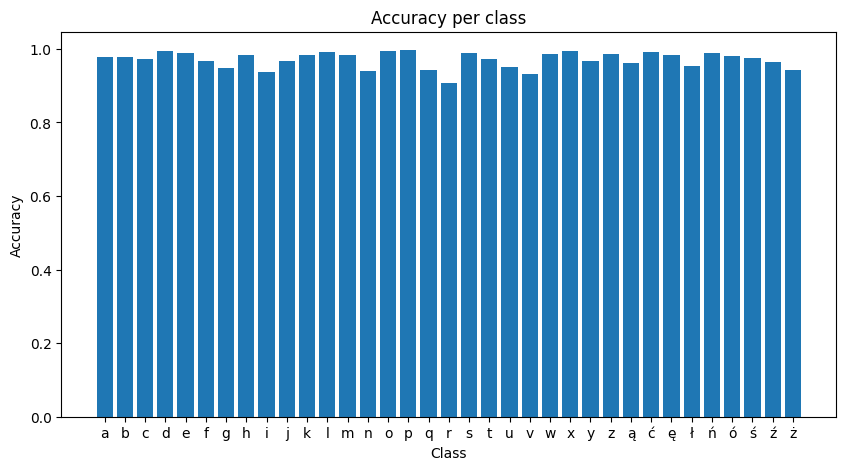

{'test_loss': 0.08983851969242096, 'test_accuracy': 0.9702286124229431, 'num_parameters': 1179157, 'compressed_disk_size': 1459535, 'model_flops': 0, 'throughput': 15803.007827590884, 'accuracy_per_class': <wandb.data_types.Table object at 0x7f9fa0f0a700>}


accuracy,▁▅▇█
compressed_disk_size,▁
epoch,▁▃▆█
loss,█▄▂▁
model_flops,▁
num_parameters,▁
test_accuracy,▁
test_loss,▁
throughput,▁
val_accuracy,▁▅▇█
val_loss,█▄▂▁


In [11]:
# evaluate model on ds_test and log to wandb
test_loss_prune, test_acc_prune = model_sparse.evaluate(ds_test)

# calculate model size on disk, flops and number of parameters
flops = calculate_model_flops(wandb.run.summary)
num_parameters = calculate_model_num_parameters(model_sparse)
compressed_disk_size = calculate_model_compressed_size_on_disk('model_sparse.h5')
throughput = calculate_model_throughput(model_sparse, ds_test, wandb.config.batch_size)
class_acc = calculate_accuracy_per_class(model_sparse, ds_test, artifact_base_name)

data_to_log = {
    "test_loss": test_loss_prune, 
    "test_accuracy": test_acc_prune, 
    "num_parameters": num_parameters,
    "compressed_disk_size": compressed_disk_size, 
    "model_flops": flops,
    "throughput": throughput,
    "accuracy_per_class": accuracy_table(class_acc)
    }
plot_accuracy_per_class(class_acc)
print(data_to_log)
wandb.log(data_to_log)
run.finish()

# PQAT - pruning preserving quantization aware training

Epoch 1/4


2023-02-03 16:57:39.254834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:57:39.254889: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-02-03 16:57:39.255041: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-02-03 16:57:39.255559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:57:39.255894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 16:57:39.256184: I tensor

2408/2408 [==============================] - 62s 25ms/step - loss: 0.1391 - accuracy: 0.9554 - val_loss: 0.0629 - val_accuracy: 0.9770
Epoch 2/4
2408/2408 [==============================] - 60s 25ms/step - loss: 0.1108 - accuracy: 0.9619 - val_loss: 0.0523 - val_accuracy: 0.9796
Epoch 3/4
2408/2408 [==============================] - 60s 25ms/step - loss: 0.1036 - accuracy: 0.9644 - val_loss: 0.0518 - val_accuracy: 0.9794
Epoch 4/4
2408/2408 [==============================] - 60s 25ms/step - loss: 0.0950 - accuracy: 0.9671 - val_loss: 0.0489 - val_accuracy: 0.9810


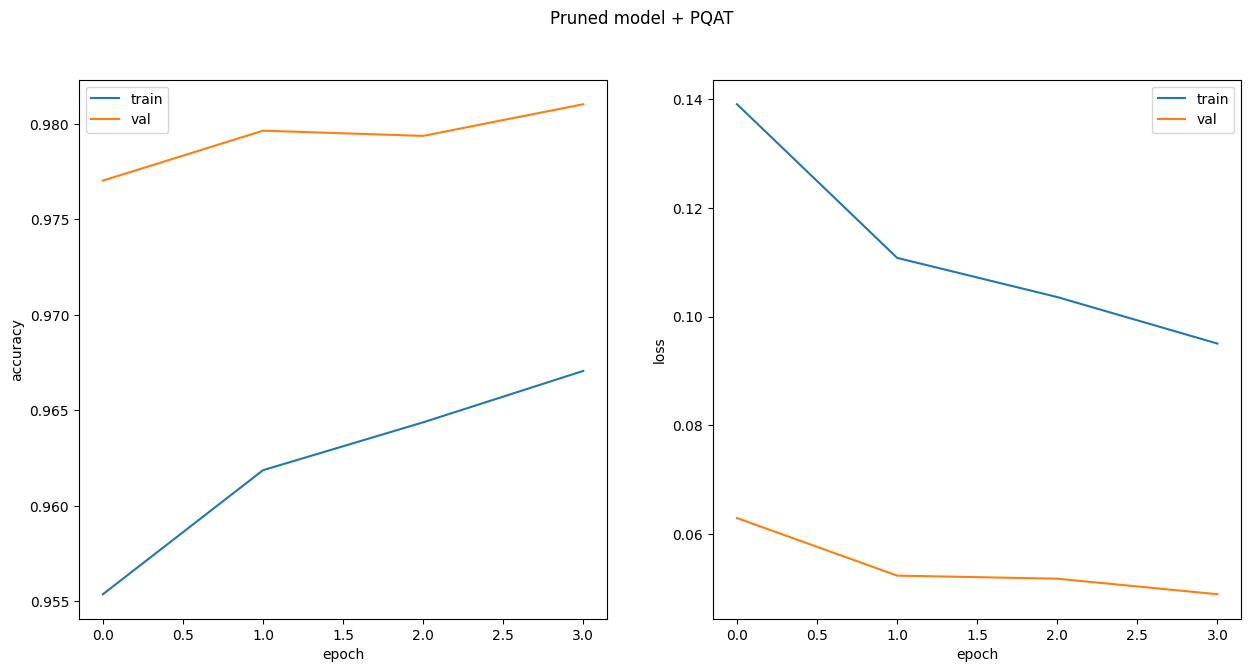

In [12]:
run = wandb.init(project="master-thesis", job_type="training", name=f"{model_name}_pqat", config=defaults, tags=[artifact_name, "optimized"])

# PQAT
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(model_sparse)
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(stripped_pruned_model)
pqat_model = tfmot.quantization.keras.quantize_apply(
              quant_aware_annotate_model,
              tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pqat_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_summary'),
    WandbCallback(
            compute_flops=True, 
            save_model=False, 
            log_weights=False, 
            log_gradients=False
        )
]

history = pqat_model.fit(
    ds_train,
    epochs=prune_epochs,
    validation_data=ds_val,
    callbacks=callbacks,
)
plot_history(history, "Pruned model + PQAT")
tf.keras.models.save_model(pqat_model, 'model_quantized_sparse.h5', include_optimizer=False)

344/344 [==============================] - 3s 8ms/step


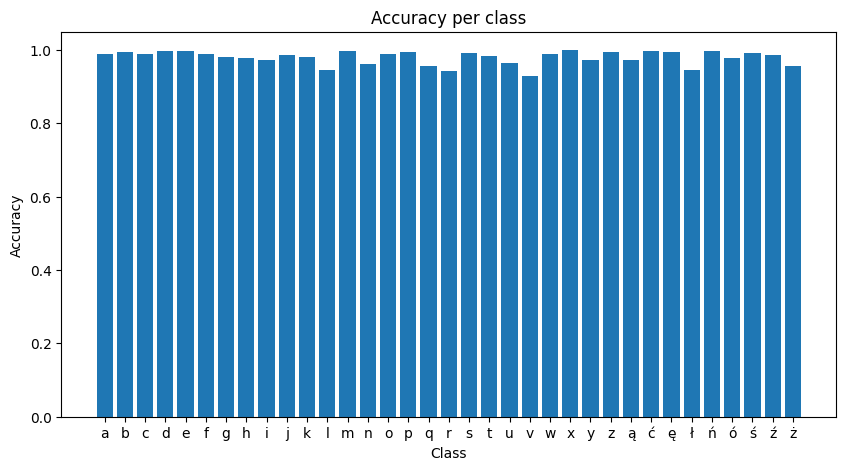

{'test_loss': 0.05208973586559296, 'test_accuracy': 0.979819118976593, 'num_parameters': 590660, 'compressed_disk_size': 1340898, 'model_flops': 0.005704217, 'throughput': 7463.815367814897, 'accuracy_per_class': <wandb.data_types.Table object at 0x7fa0045aaf70>}


accuracy,▁▅▆█
compressed_disk_size,▁
epoch,▁▃▆█
loss,█▄▂▁
model_flops,▁
num_parameters,▁
test_accuracy,▁
test_loss,▁
throughput,▁
val_accuracy,▁▆▅█
val_loss,█▃▂▁


In [13]:
# evaluate model on ds_test and log to wandb
test_loss_pqat, test_acc_pqat = pqat_model.evaluate(ds_test)

# calculate model size on disk, flops and number of parameters
flops = calculate_model_flops(wandb.run.summary)
num_parameters = calculate_model_num_parameters(pqat_model)
compressed_disk_size = calculate_model_compressed_size_on_disk('model_quantized_sparse.h5')
throughput = calculate_model_throughput(pqat_model, ds_test, wandb.config.batch_size)
class_acc = calculate_accuracy_per_class(pqat_model, ds_test, artifact_base_name)

data_to_log = {
    "test_loss": test_loss_pqat, 
    "test_accuracy": test_acc_pqat, 
    "num_parameters": num_parameters,
    "compressed_disk_size": compressed_disk_size, 
    "model_flops": flops,
    "throughput": throughput,
    "accuracy_per_class": accuracy_table(class_acc)
    }
plot_accuracy_per_class(class_acc)
print(data_to_log)
wandb.log(data_to_log)
run.finish()

# Summary & Tensorboard

In [14]:
print('Baseline test accuracy:', test_acc_before) 
print('Quantized test accuracy:', test_acc_quantize)
print('Pruned test accuracy:', test_acc_prune)
print('PQAT test accuracy:', test_acc_pqat)

Baseline test accuracy: 0.9815008640289307
Quantized test accuracy: 0.9815008640289307
Pruned test accuracy: 0.9702286124229431
PQAT test accuracy: 0.979819118976593


In [15]:
print('Zipped model files size:\n')
b_size = os.path.getsize('model_baseline.h5.zip')
q_size = os.path.getsize('model_quantized.h5.zip')
s_size = os.path.getsize('model_sparse.h5.zip')
q_s_size = os.path.getsize('model_quantized_sparse.h5.zip')

print('Baseline: {} bytes'.format(b_size))
print('Quantized: {} bytes'.format(q_size))
print('Sparse:   {} bytes'.format(s_size))
print('PQAT:     {} bytes'.format(q_s_size))

print(f'Quantized model is {((b_size-q_size)/b_size * 100):.2f}% smaller')
print(f'Pruned model is {((b_size-s_size)/b_size * 100):.2f}% smaller')
print(f'PQAT model is {((b_size-q_s_size)/b_size * 100):.2f}% smaller')

Zipped model files size:

Baseline: 2208670 bytes
Quantized: 2213573 bytes
Sparse:   1459535 bytes
PQAT:     1340898 bytes
Quantized model is -0.22% smaller
Pruned model is 33.92% smaller
PQAT model is 39.29% smaller


In [ ]:
%load_ext tensorboard
%tensorboard --logdir prune_summary